In [69]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from utils.Dataset import CraneDataset
from tensorflow import keras
from utils.layer import DecompositionLayer
from utils.detect_roll_over import calculate_load_margin
from utils.miscellaneous import create_seq_dataset_multiple_input_single_output
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from tqdm.notebook import tqdm

In [70]:
model = keras.models.load_model("models/model.keras", custom_objects={'DecompositionLayer': DecompositionLayer})

In [71]:
data_file_path_list = []
data_file_name_list = os.listdir('data')

for file_name in data_file_name_list:
    data_file_path_list.append(os.path.join('data', file_name))

dataset_inst = CraneDataset(data_file_path_list)
raw_dataset = dataset_inst.get_dataset()
dataset = raw_dataset.copy()
dataset = dataset.iloc[0::10]
dataset.reset_index(drop=True, inplace=True)

feature_name_list = dataset_inst.get_data_feature_names()
target_name_list = dataset_inst.get_data_target_names()

for target_name in target_name_list:
    dataset[target_name] = dataset[target_name]/1000

dataset = dataset[dataset['Time(sec)']>5]
dataset.reset_index(drop=True, inplace=True)

  0%|          | 0/22 [00:00<?, ?it/s]

In [72]:
left_load_name_list = ['Actual_Load_Left_1(N)', 'Actual_Load_Left_2(N)', 'Actual_Load_Left_3(N)', 'Actual_Load_Left_4(N)', 'Actual_Load_Left_5(N)']
right_load_name_list = ['Actual_Load_Right_1(N)', 'Actual_Load_Right_2(N)', 'Actual_Load_Right_3(N)', 'Actual_Load_Right_4(N)', 'Actual_Load_Right_5(N)']

front_load_name_list = ['Actual_Load_Left_1(N)', 'Actual_Load_Left_2(N)', 'Actual_Load_Right_1(N)', 'Actual_Load_Right_2(N)']
rear_load_name_list = ['Actual_Load_Left_4(N)', 'Actual_Load_Left_5(N)', 'Actual_Load_Right_4(N)', 'Actual_Load_Right_5(N)']

left_load_margin_list = []
right_load_margin_list = []
front_load_margin_list = []
rear_load_margin_list = []
roll_over_det_list = []

n_file = int(dataset['file_idx'].max()+1)

for file_idx in tqdm(range(n_file)):
    data_sample = dataset[dataset['file_idx']==file_idx]

    for i in range(data_sample.shape[0]):
        sample = data_sample.iloc[i, :]
        load_arr = sample[left_load_name_list+right_load_name_list].to_numpy()
        swing_angle = sample['Swing_Angle(deg)'].item()

        load_margin_array, rollover_det = calculate_load_margin(ground_load=load_arr, swing_angle=swing_angle)

        left_load_margin_list.append(load_margin_array[0])
        right_load_margin_list.append(load_margin_array[1])
        front_load_margin_list.append(load_margin_array[2])
        rear_load_margin_list.append(load_margin_array[3])
        roll_over_det_list.append(int(rollover_det))

left_load_margin_arr = np.array(left_load_margin_list)
right_load_margin_arr = np.array(right_load_margin_list)
front_load_margin_arr = np.array(front_load_margin_list)
rear_load_margin_arr = np.array(rear_load_margin_list)
roll_over_det_arr = np.array(roll_over_det_list)

dataset = pd.concat([dataset, pd.DataFrame(roll_over_det_arr, columns=['roll_over_det'])], axis=1)

  0%|          | 0/22 [00:00<?, ?it/s]

In [75]:
seq_len = 30
pred_distance = 30

train_feature, train_target = create_seq_dataset_multiple_input_single_output(data=augment_dataset,
                                                                              seq_len=seq_len,
                                                                              pred_distance=pred_distance,
                                                                              target_idx_pos=augment_dataset.shape[1])
train_target = np.squeeze(train_target)

print(train_feature.shape, train_target.shape)

creating sequence dataset...:   0%|          | 0/1944969 [00:00<?, ?it/s]

(1944940, 30, 7) (1944940, 0)


In [53]:
train_pred = model.predict(train_feature, verbose=1)
train_pred = np.squeeze(train_pred)

282/282 [==============================] - 4s 14ms/step


In [54]:
train_pred_binary = np.where(train_pred>0.7, 1, 0)

(4000.0, 5000.0)

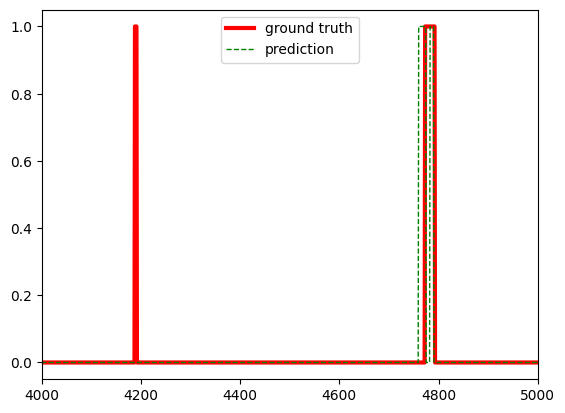

In [45]:
sns.lineplot(train_target, label='ground truth', color='red', linewidth=3)
sns.lineplot(train_pred, label='prediction', linestyle='--', color='green', linewidth=1)

plt.xlim(4000, 5000)

In [49]:
# 2. 혼동 행렬 (Confusion Matrix) 계산
# TN, FP, FN, TP 순서로 배열을 반환합니다.
tn, fp, fn, tp = confusion_matrix(y_true=train_target, y_pred=train_pred).ravel()

print(f"진양성 (TP): {tp}")
print(f"진음성 (TN): {tn}")
print(f"위양성 (FP): {fp}")
print(f"위음성 (FN): {fn}")

진양성 (TP): 725
진음성 (TN): 8118
위양성 (FP): 49
위음성 (FN): 102


In [47]:
# 3. 주요 성능 지표 계산
# 정확도 (Accuracy)
accuracy = accuracy_score(y_true=train_target, y_pred=train_pred)
# 정밀도 (Precision)
precision = precision_score(y_true=train_target, y_pred=train_pred)
# 재현율 (Recall)
recall = recall_score(y_true=train_target, y_pred=train_pred)
# F1 점수 (F1 Score)
f1 = f1_score(y_true=train_target, y_pred=train_pred)
# AUC (Area Under the ROC Curve)
auc = roc_auc_score(y_true=train_target, y_score=train_pred)

print("--- 주요 성능 지표 ---")
print(f"정확도: {accuracy:.4f}")
print(f"정밀도: {precision:.4f}")
print(f"재현율: {recall:.4f}")
print(f"F1 점수: {f1:.4f}")
print(f"AUC: {auc:.4f}")

--- 주요 성능 지표 ---
정확도: 0.9832
정밀도: 0.9367
재현율: 0.8767
F1 점수: 0.9057
AUC: 0.9353


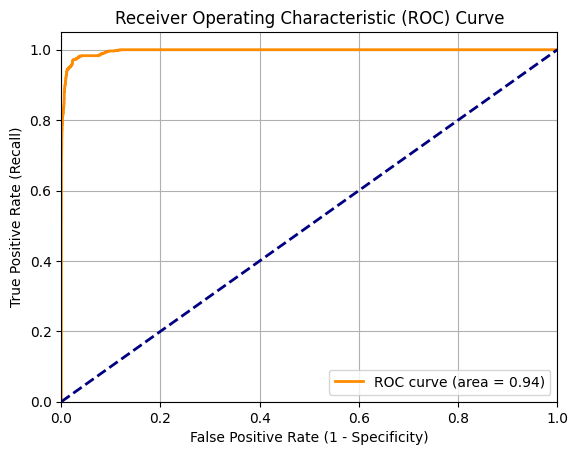

In [56]:
# 4. ROC 곡선 시각화
# ROC curve 계산
fpr, tpr, thresholds = roc_curve(y_true=train_target, y_score=train_pred)

# 그래프 그리기
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # 50% 수준의 랜덤 모델
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)